In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
%matplotlib inline

In [2]:
shelterDf = pd.read_csv('Austin_Animal_Center_Outcomes.csv')

In [3]:
shelterDf.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A682730,Freddy,03/19/2019 06:54:00 PM,03/19/2019 06:54:00 PM,07/04/2013,Return to Owner,NaN,Dog,Neutered Male,5 years,Pit Bull Mix,Fawn
1,A790982,Blue,03/19/2019 06:54:00 PM,03/19/2019 06:54:00 PM,12/19/2017,Return to Owner,NaN,Dog,Intact Male,1 year,Pit Bull Mix,Blue/White
2,A790653,*O'Brian,03/19/2019 06:35:00 PM,03/19/2019 06:35:00 PM,09/13/2017,Adoption,NaN,Dog,Spayed Female,1 year,Pembroke Welsh Corgi Mix,Red/White
3,A475011,Tobie,03/19/2019 06:14:00 PM,03/19/2019 06:14:00 PM,05/11/2006,Return to Owner,NaN,Dog,Intact Male,12 years,German Shepherd Mix,Black/White
4,A790581,Mia,03/19/2019 06:11:00 PM,03/19/2019 06:11:00 PM,03/12/2018,Adoption,NaN,Dog,Spayed Female,1 year,Pit Bull Mix,Black/White


In [4]:
shelterDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97101 entries, 0 to 97100
Data columns (total 12 columns):
Animal ID           97101 non-null object
Name                67197 non-null object
DateTime            97101 non-null object
MonthYear           97101 non-null object
Date of Birth       97101 non-null object
Outcome Type        97093 non-null object
Outcome Subtype     43953 non-null object
Animal Type         97101 non-null object
Sex upon Outcome    97099 non-null object
Age upon Outcome    97093 non-null object
Breed               97101 non-null object
Color               97101 non-null object
dtypes: object(12)
memory usage: 8.9+ MB


In [5]:
shelterDf.nunique()

Animal ID           87157
Name                16563
DateTime            80244
MonthYear           80244
Date of Birth        6371
Outcome Type            9
Outcome Subtype        20
Animal Type             5
Sex upon Outcome        5
Age upon Outcome       49
Breed                2372
Color                 567
dtype: int64

In [6]:
shelterDf['Animal Type'].value_counts()

Dog          55508
Cat          35964
Other         5165
Bird           452
Livestock       12
Name: Animal Type, dtype: int64

We're going to focus on cats and dogs

**Clean Data**

There is a lot of subjectivity in determining an animals breed and color e.g. many of the colors/breeds have only one animal assigned to that type. Therefore, we are only going to be looking at the top 10 breeds and drop the color feature

In [7]:
print('--Breeds--')
print(shelterDf['Breed'].value_counts().tail(10))
print('--Colors--')
print(shelterDf['Color'].value_counts().tail(10))

--Breeds--
Norwich Terrier/Chihuahua Longhair    1
Scottish Terrier/Cairn Terrier        1
Australian Shepherd/Siberian Husky    1
English Bulldog/Pit Bull              1
Chow Chow/Australian Kelpie           1
Pekingese/Tibetan Terrier             1
Whippet/Beagle                        1
American Sable                        1
English Bulldog/Beagle                1
Chihuahua Shorthair/Border Collie     1
Name: Breed, dtype: int64
--Colors--
Agouti/Gray                 1
Blue Smoke/Brown            1
Brown Merle/Gray            1
Fawn/Chocolate              1
Blue Cream/Buff             1
Red Tick/Black              1
Brown Brindle/Blue Cream    1
Black/Seal Point            1
Tortie/Tortie               1
Brown Brindle/Gray          1
Name: Color, dtype: int64


In [8]:
shelterDf = shelterDf[shelterDf.groupby('Breed').Breed.transform(len) > 1000]
print('Number of Breeds: ' + str(shelterDf['Breed'].nunique()))
print('Number of Animals: ' + str(shelterDf['Breed'].count()))

Number of Breeds: 10
Number of Animals: 58935


In [9]:
print(shelterDf[shelterDf['Animal Type'] == 'Other']['Breed'].value_counts())
print(shelterDf[shelterDf['Animal Type'] == 'Other']['Outcome Type'].value_counts())

Bat Mix    1680
Name: Breed, dtype: int64
Euthanasia    1464
Disposal       169
Died            44
Name: Outcome Type, dtype: int64


The animals in the 'other' category are all bats and I highly doubt bats are up for adoption. They will be dropped from the data set

In [10]:
shelterDf = shelterDf[shelterDf['Animal Type'] != 'Other']

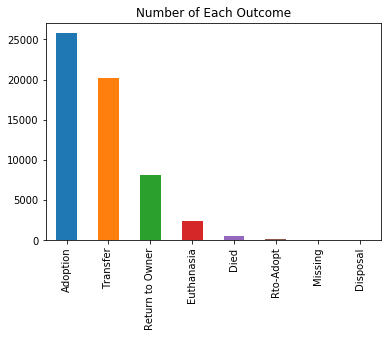

In [11]:
shelterDf['Outcome Type'].value_counts().plot(kind = 'bar', title = 'Number of Each Outcome')
plt.show()

Seems to be a pretty effective shelter although transfer doesn't mean adopted rather they were trasfered to another facility 

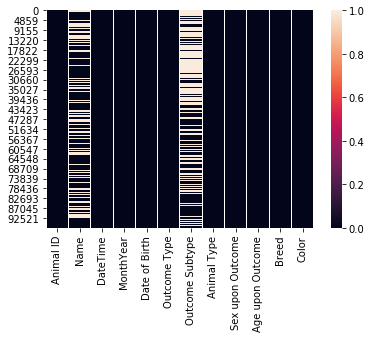

In [12]:
sns.heatmap(shelterDf.isnull())
plt.show()

In [13]:
shelterDf.isnull().sum()

Animal ID               0
Name                19061
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            3
Outcome Subtype     28595
Animal Type             0
Sex upon Outcome        1
Age upon Outcome        4
Breed                   0
Color                   0
dtype: int64

Lets get rid of a few of those missing values 

In [14]:
shelterDf = shelterDf[shelterDf['Sex upon Outcome'].isnull() == False]
shelterDf = shelterDf[shelterDf['Outcome Type'].isnull() == False]

In [15]:
shelterDf.isnull().sum()

Animal ID               0
Name                19060
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            0
Outcome Subtype     28592
Animal Type             0
Sex upon Outcome        0
Age upon Outcome        2
Breed                   0
Color                   0
dtype: int64

The missing 'Age upon Outcome' wont be a problem since I will be calculating it a different way below

Will be best to just drop Name and Outcome Subtype (will drop later)

In [16]:
# Add feature 'Was Adopted', 1 is adopted, 0 not adopted
shelterDf['Was Adopted'] = shelterDf['Outcome Type'].apply(lambda x: 1 if x == 'Adoption' else 0)

In [17]:
# If the 'name' column has a float then its NaN
shelterDf['Has Name'] = shelterDf['Name'].apply(lambda x: 1 if not isinstance(x, float) else 0)

In [18]:
# Make 'datetime' and 'date_of_birth' datetime objects
# There is several typos in Date of Birth so we'll drop those
shelterDf['DateTime'] = shelterDf['DateTime'].apply(lambda x: datetime.datetime.strptime(x[0:-3], '%m/%d/%Y %H:%M:%S'))
shelterDf['Date of Birth'] = shelterDf['Date of Birth'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))

In [19]:
# Make 'month' and 'year' features
shelterDf['Month'] = shelterDf['DateTime'].apply(lambda x: x.month)
shelterDf['Year'] = shelterDf['DateTime'].apply(lambda x: x.year)

In [20]:
# Change 'age upon outcome' to days for cosistency
shelterDf['Age upon Outcome'] = shelterDf['DateTime'] - shelterDf['Date of Birth']
daysRegex = re.compile('\d+')
shelterDf['Age upon Outcome'] = shelterDf['Age upon Outcome'].apply(lambda x: round(int(daysRegex.search(str(x)).group())))

In [21]:
# Data starts in 2013 and is incomplete
shelterDf['Year'].value_counts()

2015    11034
2016    10876
2017    10726
2014    10425
2018     9912
2013     2554
2019     1725
Name: Year, dtype: int64

They started data collection in 2013 and its only March 2019 currently, so its expected to have much less animals in those years

In [22]:
# To use 'year' as a predictor we can only use complete years
shelterDf = shelterDf[shelterDf['Year'] != 2013]
shelterDf = shelterDf[shelterDf['Year'] != 2019]

In [23]:
shelterDf['Sex upon Outcome'].value_counts()

Neutered Male    17913
Spayed Female    17096
Intact Female     7586
Intact Male       7369
Unknown           3009
Name: Sex upon Outcome, dtype: int64

In [24]:
# Dropping unknown sex upon outcome since they dont give us much information
shelterDf = shelterDf[shelterDf['Sex upon Outcome'] != 'Unknown']

In [25]:
# Seperate 'Sex upon outcome' into 'is male' and 'is fixed'
# 'is fixed' = 0 implies the animal is not spayed or neutered
sexRegex = re.compile('(\w*)\s*(Male|Female|Unknown)')
sexRegex.search('Unknown').groups()

shelterDf['is male'] = shelterDf['Sex upon Outcome'].apply(lambda x: int(sexRegex.search(str(x)).group(2) == 'Male'))
shelterDf['is fixed'] = shelterDf['Sex upon Outcome'].apply(lambda x: int(sexRegex.search(str(x)).group(1) in ['Spayed', 'Neutered']))


*Drop any columns that are no longer needed*

In [26]:
# Drop Name and Outcome Subtype: too many NaN
# Drop MonthYear: redundant
# Drop Color
# Drop Animal ID
# Drop DateTime
# Drop Date of Birth
# Drop Sex upon Outcome
shelterDf.drop(['Date of Birth','DateTime', 'Name', 'Outcome Subtype', 'Outcome Type', 'MonthYear', 'Color', 'Animal ID', 'Sex upon Outcome'], axis = 1, inplace = True)
shelterDf.dropna(inplace = True)

In [27]:
shelterDf.isnull().sum()

Animal Type         0
Age upon Outcome    0
Breed               0
Was Adopted         0
Has Name            0
Month               0
Year                0
is male             0
is fixed            0
dtype: int64

In [28]:
shelterDf.reset_index(inplace=True, drop=True)
shelterDf.head(3)

,Animal Type,Age upon Outcome,Breed,Was Adopted,Has Name,Month,Year,is male,is fixed
0,Dog,228,German Shepherd Mix,1,1,12,2018,1,0
1,Cat,61,Domestic Shorthair Mix,1,0,12,2018,0,1
2,Cat,1096,Domestic Shorthair Mix,1,1,12,2018,0,1


In [29]:
shelterDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49964 entries, 0 to 49963
Data columns (total 9 columns):
Animal Type         49964 non-null object
Age upon Outcome    49964 non-null int64
Breed               49964 non-null object
Was Adopted         49964 non-null int64
Has Name            49964 non-null int64
Month               49964 non-null int64
Year                49964 non-null int64
is male             49964 non-null int64
is fixed            49964 non-null int64
dtypes: int64(7), object(2)
memory usage: 3.4+ MB


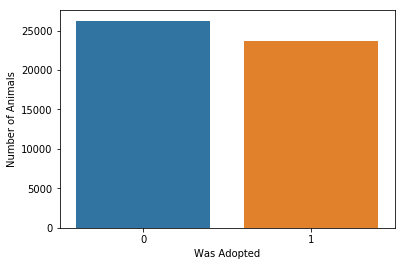

In [30]:
# Take a quick look at number of adoptions vs number of non-adoptions
sns.countplot(shelterDf['Was Adopted']).set_ylabel('Number of Animals')
plt.show()

About a 50-50 split showing that the data is fairly symmetric and predictions wont be too skewed toward adopted or not adopted

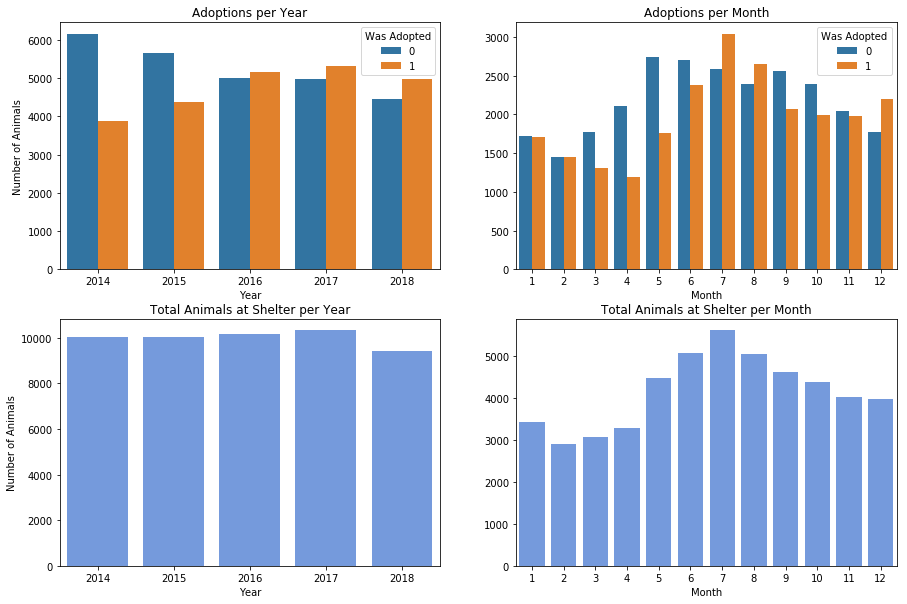

In [31]:
# Graphs of adoptions per year and per month
fig, axes = plt.subplots(figsize = (15,10), ncols =2, nrows = 2)
sns.countplot(shelterDf['Year'], hue = shelterDf['Was Adopted'], ax = axes[0,0]).set_title('Adoptions per Year')
sns.countplot(shelterDf['Month'],hue = shelterDf['Was Adopted'], ax = axes[0,1]).set_title('Adoptions per Month')
sns.countplot(shelterDf['Year'], ax = axes[1,0], color = 'cornflowerblue').set_title('Total Animals at Shelter per Year')
sns.countplot(shelterDf['Month'], ax = axes[1,1], color = 'cornflowerblue').set_title('Total Animals at Shelter per Month')

axes[0,0].set_ylabel('Number of Animals')
axes[1,0].set_ylabel('Number of Animals')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')
plt.show()

There appears to be a slight increase in adoptions from 2014 to 2018 while the total number of animals remains roughly the same. 

Adoptions in early months are significantly less than in later months but there are also less animals in the shelter in total. This makes sense since the increase in adoption at the end of the year will result in people not needing a pet and less animals in the shelter. The late year influx in adoptions is likely do to the holiday season and new pets being given as gifts

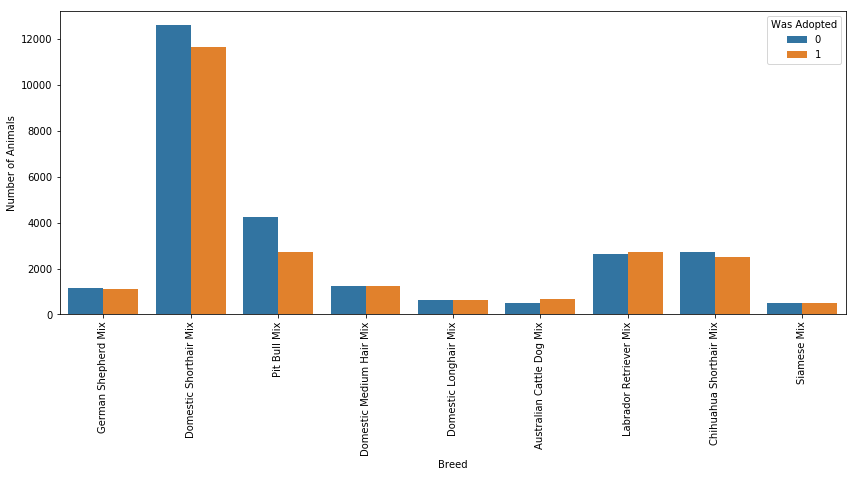

In [32]:
plt.figure(figsize= (12,5))
sns.countplot(x = 'Breed', data = shelterDf, hue = 'Was Adopted')
plt.tight_layout()
plt.xticks(rotation = 90)
plt.ylabel('Number of Animals')
plt.show()

It wouldn't seem that breed has much impact on whether an animal get adopted either and should be dropped during pre-processing. 'Domestic Shorthair Mix' is the most common breed. I assume that is because its difficult to classify cats any further than 'Short hair', 'Long hair', etc.

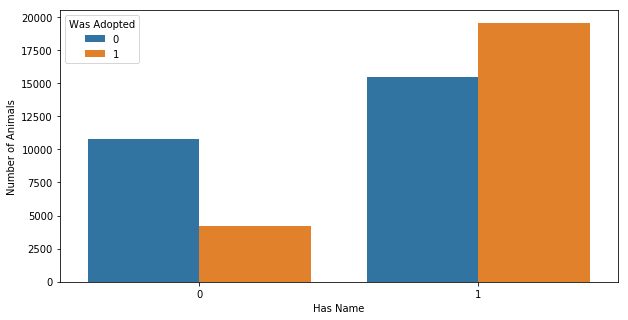

In [33]:
plt.figure(figsize= (10,5))
df = shelterDf.sample(frac = 0.01).reset_index(drop=True)

sns.countplot(shelterDf['Has Name'], hue = shelterDf['Was Adopted']).set_ylabel('Number of Animals')
plt.show()

It is clear that animals with names were much more likely to get adopted. This could be because a named animal is more likely to be well behaved and healthy, since it would likely have come from a home rather than the streets. However, there could also be cases were the shelter names found animals themselves. 

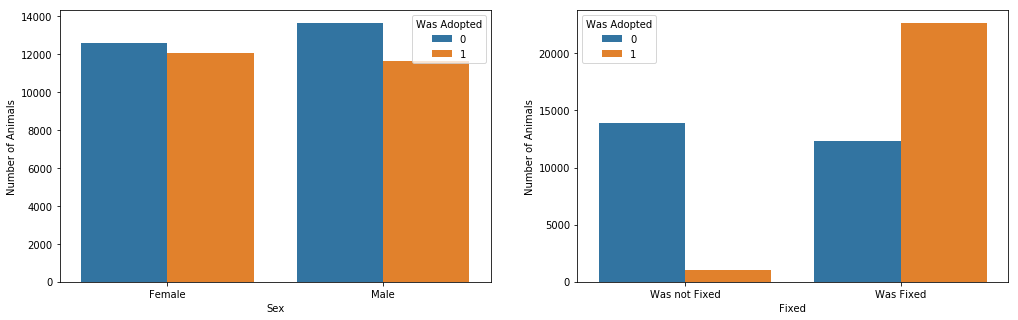

In [34]:
f,axes = plt.subplots(ncols = 2, figsize = (17,5))
sns.countplot(data = shelterDf, x = 'is male', hue = 'Was Adopted', ax = axes[0])
sns.countplot(data = shelterDf, x = 'is fixed', hue = 'Was Adopted', ax = axes[1])
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Number of Animals')
axes[0].set_xticklabels(['Female', 'Male'])
axes[1].set_xlabel('Fixed')
axes[1].set_ylabel('Number of Animals')
axes[1].set_xticklabels(['Was not Fixed', 'Was Fixed'])

plt.show()

The sex of the animal doesnt seem to matter much in terms of adoption. In the 'Fixed' graph you can clearly see that very few animals that were adopted were not fixed. 'is fixed' will likely be a very strong predictor of animal adoption

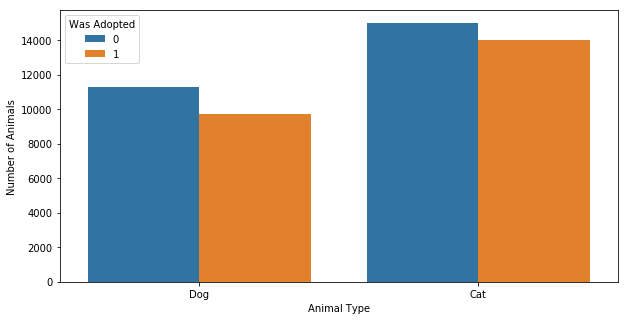

In [35]:
plt.figure(figsize = (10,5))
sns.countplot(data = shelterDf, x = 'Animal Type', hue = 'Was Adopted')
plt.ylabel('Number of Animals')
plt.show()

Adoption across based on Animal Type seems to be about the same with a little less than half of both cats and dogs being adopted.

C:\Users\Mattm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


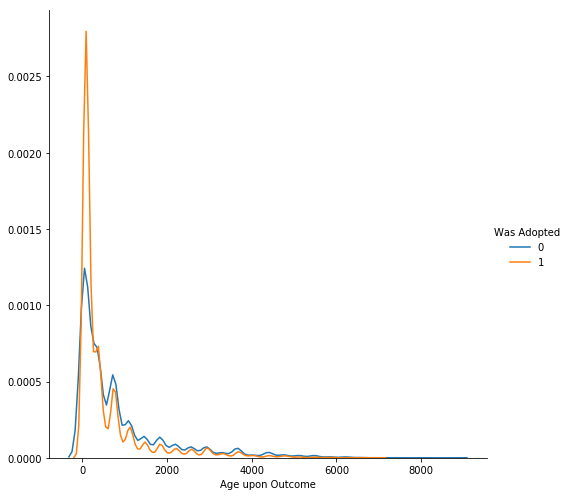

In [36]:
f = sns.FacetGrid(shelterDf, hue="Was Adopted", height=7)
f.map(sns.kdeplot, "Age upon Outcome") 
f.add_legend()
plt.show()

Clear that majority of adoptions and outcomes in general happen when the animals are young. There is a peak at about the 2 year mark (730 days). This could be due to the shelter having an age limit when an animals needs to be adopted, transfered, etc. This will likely be a strong predictor for the later models.

**Preproccessing for machine learning**

Based on the previous graphs 'Breed', 'Animal Type', and 'is male' dont seem to have a significant impact on whether an animal will be adopted so they will be dropped.

In [37]:
shelterDf.drop(['Animal Type', 'Breed', 'is male'], axis = 1, inplace = True)

'Sex upon outcome' needs to be encoded to dummy variables to be used by a machine learning model

In [38]:
shelterDf.head(3)

,Age upon Outcome,Was Adopted,Has Name,Month,Year,is fixed
0,228,1,1,12,2018,0
1,61,1,0,12,2018,1
2,1096,1,1,12,2018,1


In [39]:
shelterDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49964 entries, 0 to 49963
Data columns (total 6 columns):
Age upon Outcome    49964 non-null int64
Was Adopted         49964 non-null int64
Has Name            49964 non-null int64
Month               49964 non-null int64
Year                49964 non-null int64
is fixed            49964 non-null int64
dtypes: int64(6)
memory usage: 2.3 MB


Standardize values of 'Month' and 'Age upon Outcome'

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler()

In [42]:
shelterDf['Age upon Outcome'] = scaler.fit_transform(shelterDf['Age upon Outcome'].values.reshape(-1,1))

C:\Users\Mattm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mattm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
shelterDf['Month'] = scaler.fit_transform(shelterDf['Month'].values.reshape(-1,1))

C:\Users\Mattm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mattm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [44]:
shelterDf['Year'] = scaler.fit_transform(shelterDf['Year'].values.reshape(-1,1))

C:\Users\Mattm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mattm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [45]:
shelterDf.head()

,Age upon Outcome,Was Adopted,Has Name,Month,Year,is fixed
0,-0.477748,1,1,1.593411,1.440512,0
1,-0.637510,1,0,1.593411,1.440512,1
2,0.352631,1,1,1.593411,1.440512,1
3,0.543006,1,1,1.593411,1.440512,1
4,-0.342860,1,1,1.593411,1.440512,1


**Logistical Regression**

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X = shelterDf.drop(['Was Adopted'], axis =1)
y = shelterDf['Was Adopted']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
logModel = LogisticRegression(solver='lbfgs')

In [51]:
logModel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [52]:
predictions = logModel.predict(X_test)

In [53]:
from sklearn.metrics import classification_report,confusion_matrix

In [54]:
logClass = classification_report(y_test, predictions)
logConf = confusion_matrix(y_test, predictions)

print(logClass)
print(logConf)

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      7838
           1       0.70      0.87      0.77      7152

   micro avg       0.76      0.76      0.76     14990
   macro avg       0.77      0.76      0.76     14990
weighted avg       0.78      0.76      0.76     14990

[[5166 2672]
 [ 944 6208]]


In [55]:
print('Model Accuracy: ' + str(round((5237 + 6203)/14990, 2)*100) + '%')

Model Accuracy: 76.0%


**Cross Validation**

Check to see if logistical regression will still perform well when using different training/test data

In [62]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [59]:
crossLogModel  = LogisticRegression(solver='lbfgs')

In [63]:
crossPredict = cross_val_predict(crossLogModel, X, y, cv = 5)
scores = cross_val_score(crossLogModel, X, y, cv=5, scoring= 'f1_micro')

In [64]:
print(classification_report(y, crossPredict))

              precision    recall  f1-score   support

           0       0.80      0.69      0.74     26246
           1       0.70      0.81      0.75     23718

   micro avg       0.75      0.75      0.75     49964
   macro avg       0.75      0.75      0.75     49964
weighted avg       0.75      0.75      0.75     49964



In [61]:
print("fl-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

fl-score: 0.75 (+/- 0.06)


**Conclusion**

Given how subjective some of the data we were given from this data set, Logistical Regression was still fairly accurate with an acuraccy of ~0.75. One improvement that could be made on this project would be feature engineering the 'breed' and 'color' features. For example, you could combine combine 'Brown/Black', 'Brown', 'Brown/White/Orange' all into one binary feature 'Is brown' and see if that has any relation with adoptions but I doubt an animals color is too important when someone is considering adoption.

Furthermore, if you wanted to predict multiple outcomes other than just adoption such as Adoption, Transfer, Other then this project could easily be modified to do so by not combining all non-adoption outcomes. However, based on the results of only trying to predict adoption I find it likely the predictions will be very innacurate.